<a href="https://colab.research.google.com/github/economicactivist/DS-Unit-2-Kaggle-Challenge/blob/master/Mountain_Scott_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [180]:
df.shot_made_flag.mean()

0.4729187562688064

In [0]:
baseline = df.shot_made_flag.mean()

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
train = df.head(len(df)-1709)
test = df.tail(1709)

In [183]:
(len(train) + len(test)) == (len(df))

True

In [0]:
train = train.drop(['game_id', 'game_event_id'], axis=1)
test = test.drop(['game_id', 'game_event_id'], axis=1)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [185]:
df.htm.unique()

array(['GSW', 'PHX', 'SAC', 'IND', 'MIL', 'CLE', 'BOS', 'DAL', 'SAS',
       'DEN', 'OKC', 'NJN', 'CHI', 'DET', 'PHI', 'MEM', 'NOH', 'LAL',
       'POR', 'MIN', 'HOU', 'MIA', 'ORL', 'ATL', 'CHA', 'LAC', 'UTA',
       'TOR', 'WAS', 'NYK', 'BKN', 'NOP'], dtype=object)

In [0]:
train['is_home_team'] = (train.htm == 'GSW')
test['is_home_team'] = (test.htm == 'GSW')



In [187]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type', 'scoremargin_before_shot'],
      dtype='object')

In [0]:
train['seconds_remaining_period'] = train.minutes_remaining*60 + train.seconds_remaining
test['seconds_remaining_period'] = test.minutes_remaining*60 + test.seconds_remaining

In [189]:
train.columns, test.columns

(Index(['player_name', 'period', 'minutes_remaining', 'seconds_remaining',
        'action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area',
        'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y', 'shot_made_flag',
        'game_date', 'htm', 'vtm', 'season_type', 'scoremargin_before_shot',
        'is_home_team', 'seconds_remaining_period'],
       dtype='object'),
 Index(['player_name', 'period', 'minutes_remaining', 'seconds_remaining',
        'action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area',
        'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y', 'shot_made_flag',
        'game_date', 'htm', 'vtm', 'season_type', 'scoremargin_before_shot',
        'is_home_team', 'seconds_remaining_period'],
       dtype='object'))

In [0]:
train['seconds_remaining_game'] = 12*60*(4- train.period) + train.seconds_remaining_period 
test['seconds_remaining_game'] = 12*60*(4- test.period) + test.seconds_remaining_period 

In [191]:
train.head()

,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,is_home_team,seconds_remaining_period,seconds_remaining_game
0,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,True,685,2845
1,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,True,571,2731
2,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,True,362,2522
3,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,True,589,2029
4,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,True,139,1579


###Made previous shot: Was Steph Curry's previous shot successful?

In [0]:
list_x = df.shot_made_flag.tolist()
  

In [0]:
list_x.insert(0,0)  #push the shots_made_flag column over by one 
list_y = list_x     #assign value to new list to avoid new values when cells are re-run
list_y.pop()       #remove the last value from the list so that it doesn't exceed orig length
list_z  = list_y   #assign value to new list to avoid "re-popping" when cells are re-run

train['made_prev_shot'] = list_z[:12249]



In [0]:
test['made_prev_shot'] = list_z[12249:]


In [195]:
test.head()

,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,is_home_team,seconds_remaining_period,seconds_remaining_game,made_prev_shot
12249,Stephen Curry,1,11,31,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,226,90,1,2018-10-16,GSW,OKC,Regular Season,0.0,True,691,2851,0
12250,Stephen Curry,1,7,57,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-2,63,1,2018-10-16,GSW,OKC,Regular Season,4.0,True,477,2637,1
12251,Stephen Curry,1,3,46,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,5,29,1,2018-10-16,GSW,OKC,Regular Season,4.0,True,226,2386,1
12252,Stephen Curry,1,2,58,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-6,18,0,2018-10-16,GSW,OKC,Regular Season,7.0,True,178,2338,1
12253,Stephen Curry,1,2,49,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-228,8,1,2018-10-16,GSW,OKC,Regular Season,7.0,True,169,2329,0


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
train_2009_2017 = train.head(11081)
validate_2017_2018 = train.tail(1168)

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder

In [0]:
pipeline = make_pipeline(OneHotEncoder(use_cat_names=True), RandomForestClassifier())



In [0]:
y_2009_2017_train = train_2009_2017.shot_made_flag
X_2009_2017_train = train_2009_2017.drop(y_2009_2017_train.name, axis=1)
y_2017_2018_validate = validate_2017_2018.shot_made_flag
X_2017_2018_validate = validate_2017_2018.drop(y_2017_2018_validate.name, axis=1)

In [200]:
pipeline.fit(X_2009_2017_train, y_2009_2017_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['player_name', 'action_type', 'shot_type',
                                     'shot_zone_basic', 'shot_zone_area',
                                     'shot_zone_range', 'game_date', 'htm',
                                     'vtm', 'season_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestCl...rue, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_i

In [0]:
y_pred_2017_2018 = pipeline.predict(X_2017_2018_validate)

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [202]:
pipeline.score(X_2017_2018_validate, y_2017_2018_validate)

0.601027397260274

In [0]:
y_test = test.shot_made_flag
X_test = test.drop(y_test.name, axis=1)

## 7. Get your model's test accuracy

> (One time, at the end.)

In [206]:
pipeline.score(X_test, y_test)

0.6255119953188999

###Confusion Matrix of Actual vs Predicted

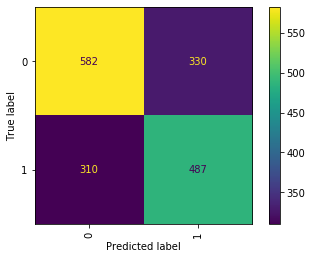

In [207]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(pipeline, X_test, y_test, values_format='.0f', xticks_rotation='vertical');

###Classification Report

In [209]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       912
           1       0.60      0.61      0.60       797

    accuracy                           0.63      1709
   macro avg       0.62      0.62      0.62      1709
weighted avg       0.63      0.63      0.63      1709



In [0]:
from sklearn.model_selection import train_test_split
y_rand = train.shot_made_flag
X_rand = train.drop(y_rand.name, axis=1)
X_train_rand, X_val_rand, y_train_rand, y_val_rand = train_test_split(X_rand, y_rand, random_state=99, test_size=.2)

In [0]:
pipeline2 = make_pipeline(OneHotEncoder(use_cat_names=True), RandomForestClassifier())

In [219]:
pipeline2.fit(X_train_rand,y_train_rand)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['player_name', 'action_type', 'shot_type',
                                     'shot_zone_basic', 'shot_zone_area',
                                     'shot_zone_range', 'game_date', 'htm',
                                     'vtm', 'season_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestCl...rue, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_i

In [0]:
y_pred_rand = pipeline2.predict(X_val_rand)

In [225]:
pipeline2.score(X_val_rand, y_val_rand)

0.6461224489795918

In [226]:
pipeline2.score(X_test,y_test)

0.6196606202457577

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [210]:
(36+85)/(85+58+8+36)   # accuracy: (tp + tn) / (p + n)

0.6470588235294118

### Calculate precision

In [211]:
36/(36+58)  # precision tp / (tp + fp)

0.3829787234042553

### Calculate recall

In [213]:
36/(36+8)# recall: tp / (tp + fn)

0.8181818181818182

###F1-Score



In [215]:
(2*36)/(2*36 + 58 + 8)# f1: 2 tp / (2 tp + fp + fn)

0.5217391304347826